In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models
from torchmetrics import Accuracy

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

from lisa import LISA
from itertools import chain

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:
device = torch.device("cpu" if torch.cuda.is_available() else "cuda")

In [3]:
epochs = 100

batch_size = 128

In [4]:
normalize = transforms.Normalize(mean=[0.4563, 0.4076, 0.3895], std=[0.2298, 0.2144, 0.2259])

lisa_transforms = transforms.Compose([ transforms.ToPILImage(),transforms.ToTensor(),normalize])

In [5]:
# dataset =  LISA(root='./datasets' , download=True, train=True, transform = lisa_transforms)

train_dataset = LISA(root='./datasets', download=True, train=True, transform = lisa_transforms)
test_dataset = LISA(root='./datasets', download=True, train=False, transform = lisa_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,) # num_workers=4,
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
classes = ('stop', 'yield', 'warning', 'speed', 'regulatory')

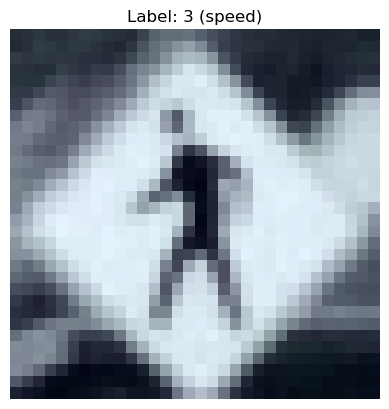

In [12]:
# Get a sample image and label
sample_index = 2000  # Change index to see different samples
image, label = train_dataset[sample_index]

# Convert the image tensor to a format suitable for display
image = image.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

# Visualize the image
plt.imshow(image)
plt.title(f"Label: {label} ({classes[label]})")  # Display the label
plt.axis('off')
plt.show()

In [17]:
%run models.ipynb
%run utils.ipynb

In [19]:
model = vgg16()
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9, weight_decay = 5e-4)

In [21]:
def train_model(model, epochs):
    model.train()
    for epoch in range(epochs):
        for x_batch, y_batch in train_dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        # Evaluate model!
        if epochs%10==0:
            predictions, labels = evaluate_model(model, test_dataloader, device)
            test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
            print(f"Epoch {epoch+1}/{epochs} - test accuracy: {(100 * test_acc):.2f}% and CE loss {loss.item():.2f}")
    return model

In [ ]:
model_normal = train_model(model = model.to(device), epochs = epochs)

In [ ]:
# Model to GPU and eval mode.
model_normal.to(device)
model_normal.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_normal, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

In [ ]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_normal.pth"
model_save_path = model_path / model_name

print(f"Saving the model: {model_save_path}")
torch.save(obj=model_normal.state_dict(), f=model_save_path)

In [ ]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_normal.pth"
model_save_path = model_path / model_name
model = vgg16().to(device)
model.load_state_dict(torch.load(model_save_path))

In [ ]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG LISA Normal is: {(100 * test_acc):.2f}%")